<b>Summary:</b>
1. import gold_standard dataset and noisy dataset
2. data cleaning
3. TfidfVectorizer
4. pos tag and other features

## 1. import gold_standard dataset and noisy dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics, xgboost, textblob, string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from time import time
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance
from matplotlib import pyplot
import nltk
nltk.download('stopwords')

RAN_STATE=42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivy06\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
gold_standard=pd.read_csv("wri/policy-toolkit-master/data/processed/gold_standard.csv")
gold_standard.head()

,label,sentences,class
0,0,the purpose of the middle level institutions i...,1.0
1,1,"to address these challenges, the government wi...",1.0
2,2,lack of a database and information to support ...,3.0
3,3,to contribute to efforts to reduce poverty and...,3.0
4,4,secretariat. its terms of reference will inclu...,1.0


In [3]:
noisy=pd.read_csv("wri/policy-toolkit-master/data/processed/noisy.csv")
noisy.head()

,Unnamed: 0,Unnamed: 0.1,sentences,name,country,page,languages
0,0,3,part ii farm and 6. maintenance of 1 0 per c...,../data/raw/kenya/results/Agriculture Rules/1.txt,Kenya,1,en
1,1,4,1 0. harvesting. 1 1. farm forestry compensati...,../data/raw/kenya/results/Agriculture Rules/1.txt,Kenya,1,en
2,2,21,these rules may be cited as the agriculture fa...,../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en
3,3,31,these rules shall apply for the purposes of pr...,../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en
4,4,16,"in these rules, unless the context otherwise r...",../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en


In [4]:
print(gold_standard.shape)
print(noisy.shape)

(1033, 3)
(16146, 7)


In [5]:
df1=gold_standard['sentences'].reset_index()
df1['data']='gold'
df2=noisy['sentences'].reset_index()
df2['data']='noisy'

df=pd.concat([df1,df2],ignore_index=True)

In [6]:
df.head()

,index,sentences,data
0,0,the purpose of the middle level institutions i...,gold
1,1,"to address these challenges, the government wi...",gold
2,2,lack of a database and information to support ...,gold
3,3,to contribute to efforts to reduce poverty and...,gold
4,4,secretariat. its terms of reference will inclu...,gold


In [7]:
df.shape

(17179, 3)

## 2. data cleaning

In [12]:
# NLTK Stop words
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','shall','sub', 'government','act'])

def datacleaning(text=df.sentences):
    # Convert to list
    data = text.values.tolist()
    
    data_words=[]
    data_lemmatized = []
    data_lemmatized2 = []
    allowed_postags=['NOUN', 'VERB']
    for sent in data:
        # Remove distracting single quotes
        tmp=re.sub(r"\'", "", sent)
        
        # Tokenization & Remove stopwords
        tmp=gensim.utils.simple_preprocess(str(tmp), deacc=True)
        tmp2=[]
        for item in tmp:
            if item not in stop_words:
                tmp2.append(item)
        data_words.append(tmp2)  # deacc=True removes punctuations
        
        # Lemmatization
        doc = nlp(" ".join(tmp2)) 
        token_tmp=[token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
        data_lemmatized.append(" ".join(token_tmp))
        data_lemmatized2.append(token_tmp)

    return data_lemmatized,data_lemmatized2

In [13]:
data_lemmatized, data_lemmatized2=datacleaning(df.sentences)

In [8]:
# get most frequent words
def get_top_n_words(corpus, m=None, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[m:n]

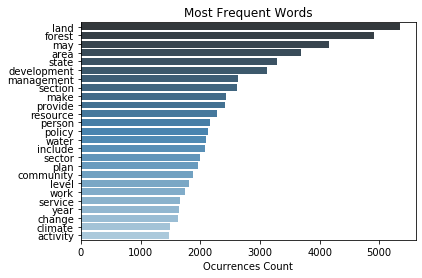

In [15]:
# the top two words are 'book' and 'read'. I removed these two words
data=get_top_n_words(data_lemmatized,0,25)
n_groups = len(data)
vals_films = [x[1] for x in data]
legends_films = [x[0] for x in data]

sns.barplot(x=vals_films, y=legends_films, palette="Blues_d", linewidth=0)
plt.xlabel("Ocurrences Count")
plt.title("Most Frequent Words")
plt.show()

## 3. TfidfVectorizer

In [16]:
tfidfconverter = TfidfVectorizer(min_df=0.001, stop_words=stopwords.words('english'))
X0 = tfidfconverter.fit_transform(data_lemmatized).toarray()
vocab=tfidfconverter.vocabulary_

X0.shape

(17179, 2261)

In [22]:
X=pd.DataFrame(X0, columns=sorted(vocab.keys()))

In [18]:
X.head()

,abadi,abandon,abandonment,ability,absence,absorption,abundance,abuse,accelerate,accept,...,write,writing,xiii,xiv,xv,year,yield,youth,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. pos tag and other features

1.Word Count of the documents – total number of words in the documents<br/>
2.Character Count of the documents – total number of characters in the documents<br/>
3.Puncutation Count in the Complete Essay – total number of punctuation marks in the documents<br/>
4.Upper Case Count in the Complete Essay – total number of upper count words in the documents<br/>
5.Title Word Count in the Complete Essay – total number of proper case (title) words in the documents<br/>
6.Frequency distribution of Part of Speech Tags

In [19]:
pos_list=['char_count', 
          'word_count', 
          'punctuation_count', 
          'title_word_count', 
          'upper_case_word_count', 
          'noun_count', 
          'verb_count', 
          'adj_count', 
          'adv_count', 
          'pron_count']

char_count = df['sentences'].apply(len)
word_count = df['sentences'].apply(lambda x: len(x.split()))
punctuation_count = df['sentences'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
title_word_count = df['sentences'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
upper_case_word_count = df['sentences'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [20]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

noun_count = df['sentences'].apply(lambda x: check_pos_tag(x, 'noun'))
verb_count = df['sentences'].apply(lambda x: check_pos_tag(x, 'verb'))
adj_count = df['sentences'].apply(lambda x: check_pos_tag(x, 'adj'))
adv_count = df['sentences'].apply(lambda x: check_pos_tag(x, 'adv'))
pron_count = df['sentences'].apply(lambda x: check_pos_tag(x, 'pron'))

In [23]:
X2=pd.DataFrame(list(char_count),columns=['char_count'])
X2['word_count'] = word_count
X2['punctuation_count'] = punctuation_count
X2['title_word_count'] = title_word_count
X2['upper_case_word_count'] = upper_case_word_count

In [21]:
len(pron_count)

17179

In [24]:
from textblob import TextBlob 
textbloblist=[]
for sent in df.sentences:
    textbloblist.append(TextBlob(sent).sentiment.polarity)
X2['senti_score']=textbloblist

In [25]:
from sklearn import preprocessing
names = X2.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(X2)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [26]:
X=pd.concat([X, scaled_df], axis=1)

# concat features with original dataset
df=pd.concat([df, X], axis=1)

In [28]:
df.head()

,index,sentences,data,abadi,abandon,abandonment,ability,absence,absorption,abundance,...,yield,youth,zone,zoo,char_count,word_count,punctuation_count,title_word_count,upper_case_word_count,senti_score
0,0,the purpose of the middle level institutions i...,gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.815786,0.688656,-0.039327,0.0,0.0,-0.122679
1,1,"to address these challenges, the government wi...",gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.978311,0.563013,0.180594,0.0,0.0,0.869564
2,2,lack of a database and information to support ...,gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.027142,-0.154943,-0.259248,0.0,0.0,0.321523
3,3,to contribute to efforts to reduce poverty and...,gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.096008,-0.154943,-0.149287,0.0,0.0,-0.688027
4,4,secretariat. its terms of reference will inclu...,gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.016123,-0.136994,-0.369208,0.0,0.0,0.431131


In [ ]:
gold_new=df[df['data']=='gold']
noisy_new=df[df['data']=='noisy']

C:\Programs\anaconda\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
gold_new.head

In [ ]:
noisy_new.head()

In [ ]:
print(gold_new.shape)
print(noisy_new.shape)

In [27]:
df.to_csv('yg2619/policy-toolkit/columbia_codes/data/new_features.csv',index=False)